# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 6

**Author 1 (sciper):** Inès Kahlaoui (310587)  
**Author 2 (sciper):** Thibault Jean-Baptiste Golaz (xxxxx)   
**Author 3 (sciper):** Marc Nicolas Domenjoz (xxxxx)   

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

..\data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

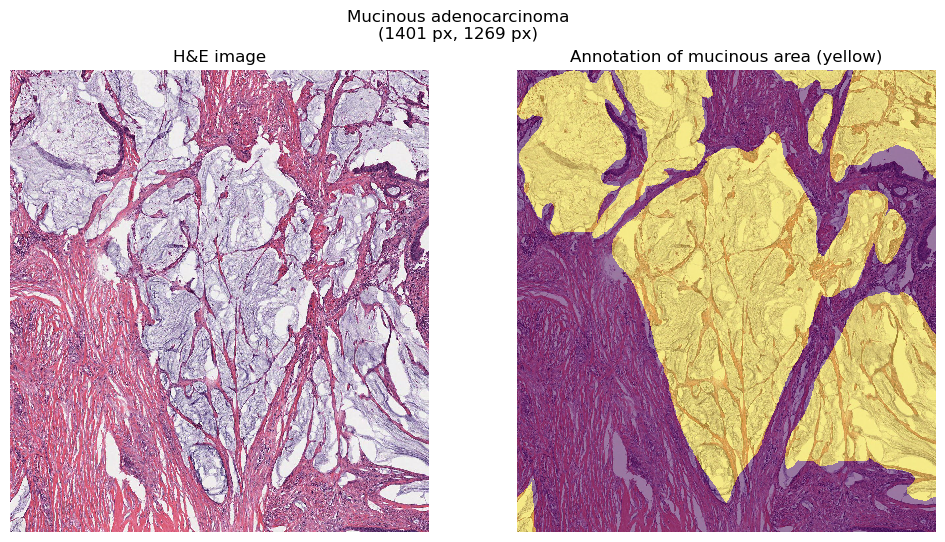

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

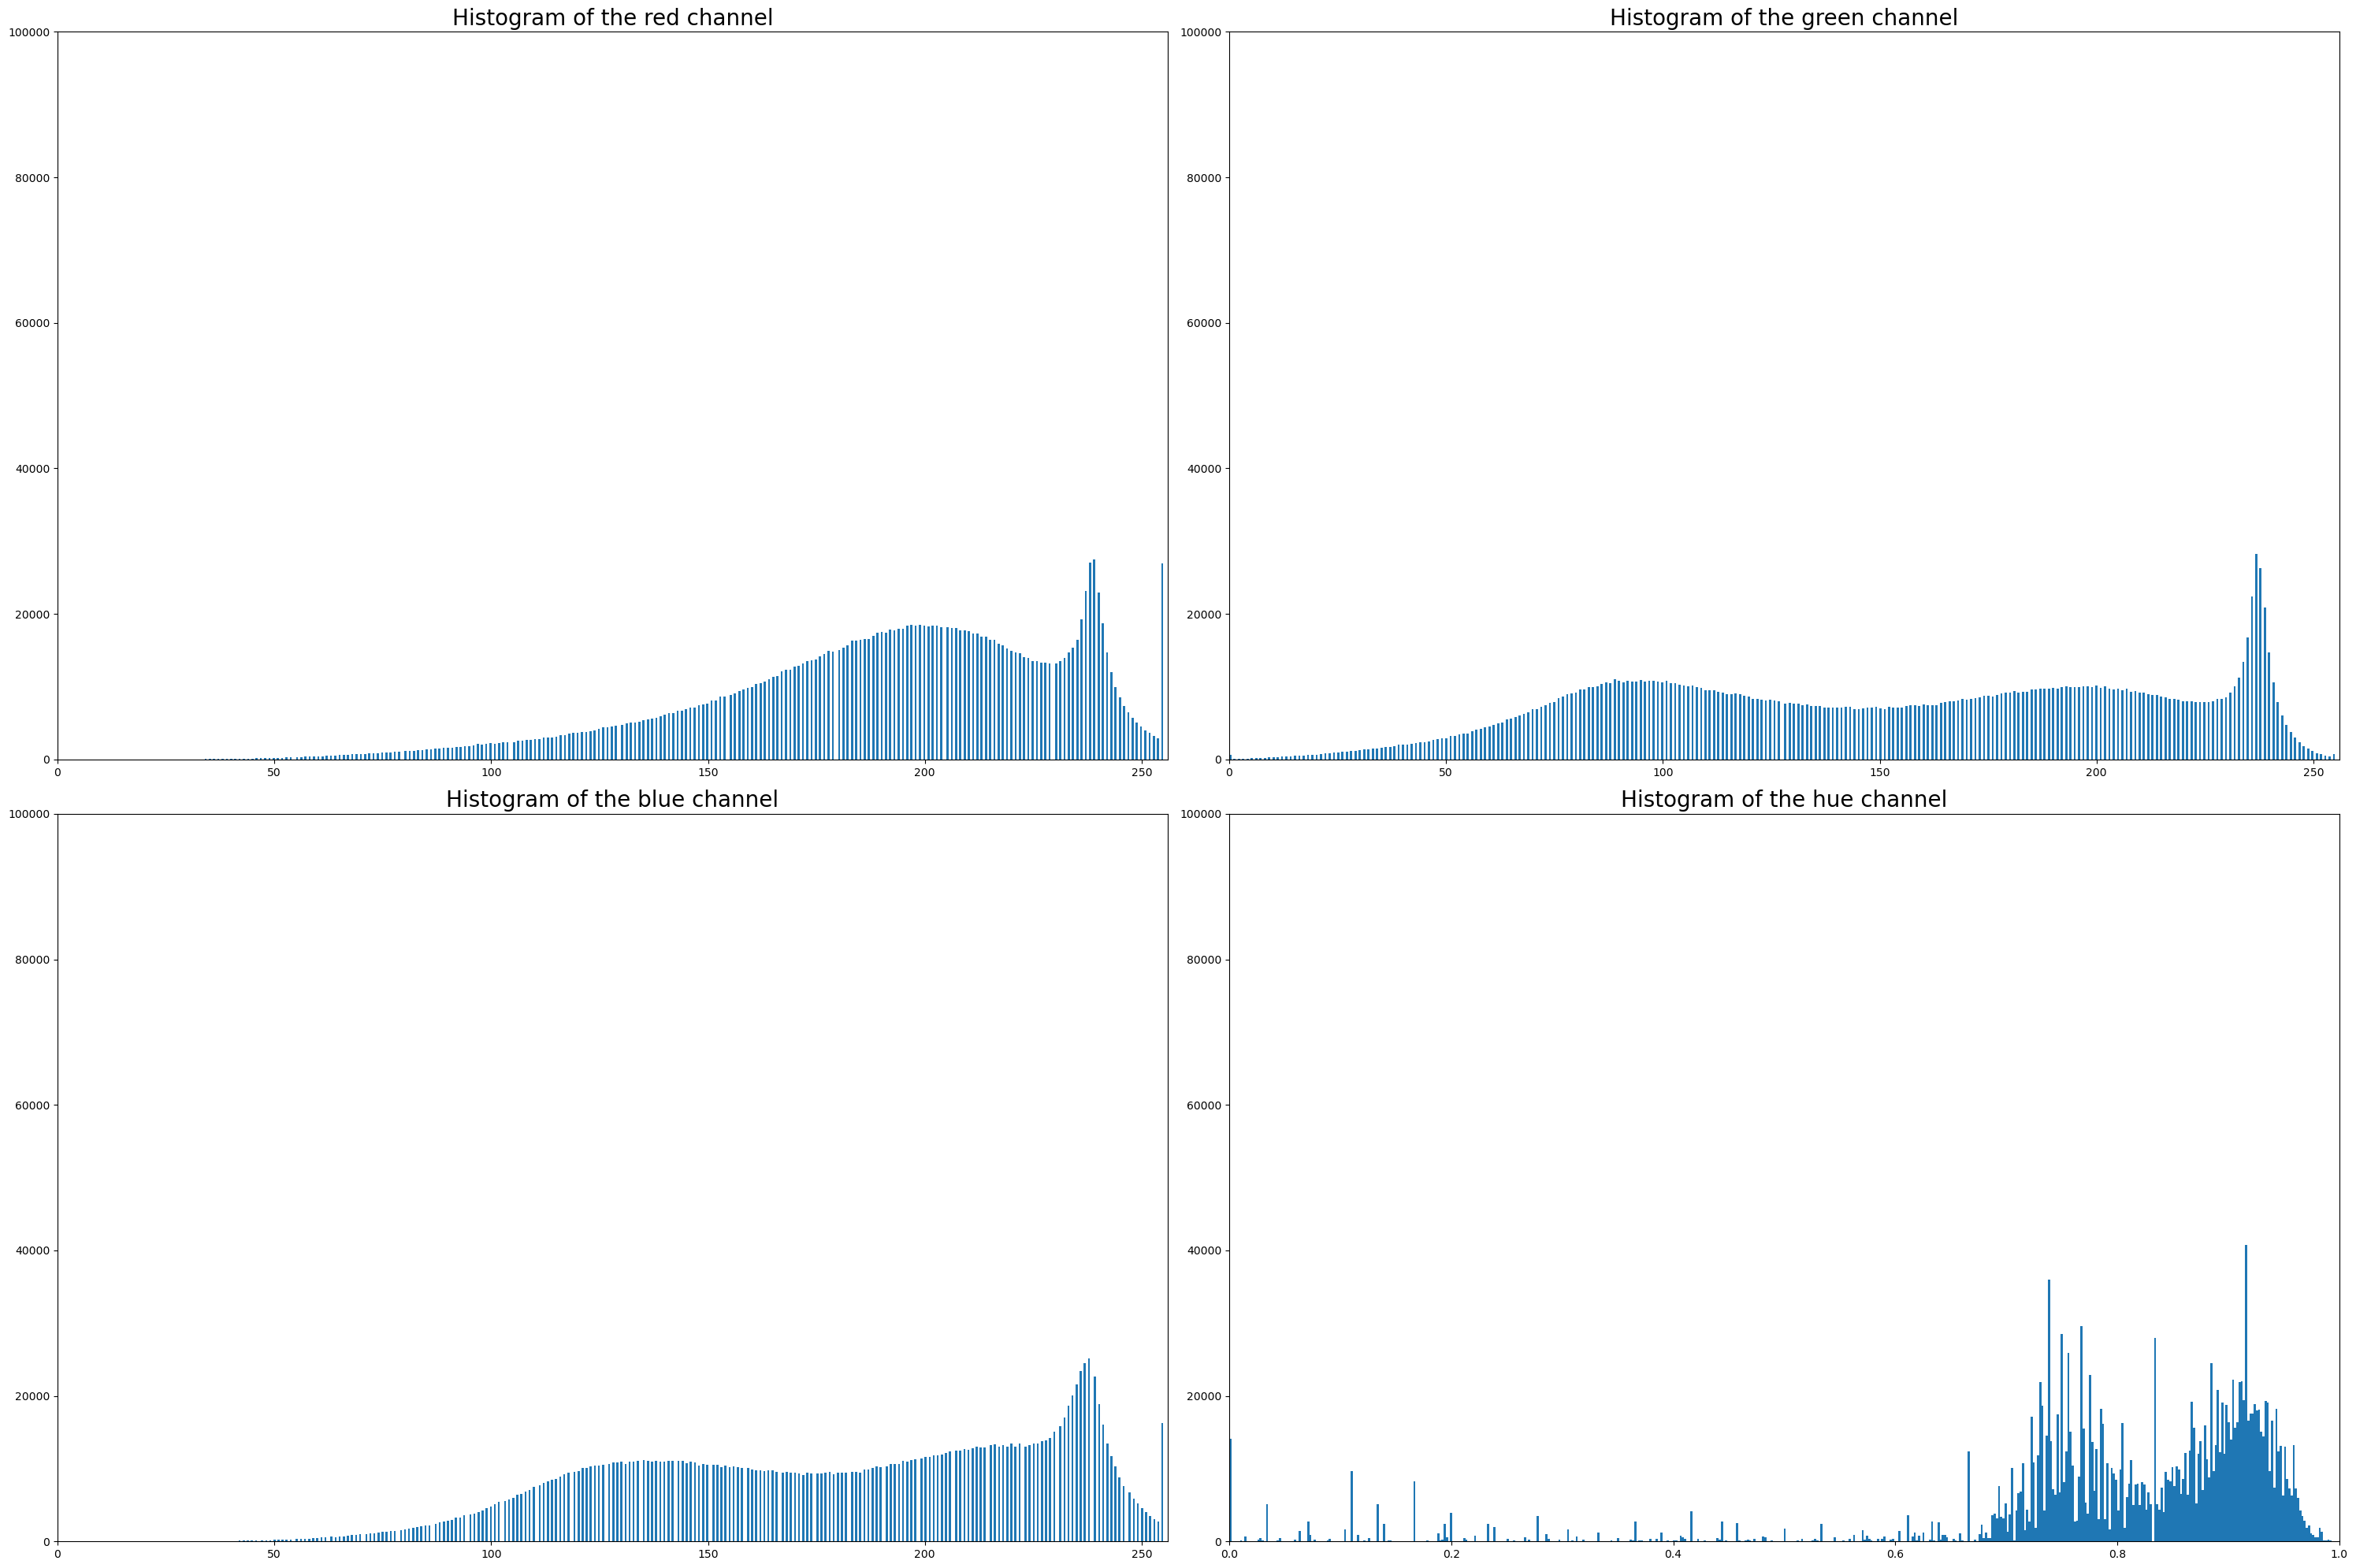

In [3]:
bins = (256,256,256,1)
channels = ["red", "green", "blue", "hue"]
# red, green, blue and hue channel images
imgs = (adeno_img[:,:,0], adeno_img[:,:,1], adeno_img[:,:,2], (skimage.color.rgb2hsv(adeno_img))[:,:,0]) 


fig, axis = plt.subplots(2, 2, figsize=(30, 20))
for i in range(2):
    for j in range(2):
        axis[i,j].hist(imgs[2*i+ j].ravel(), bins[0]*2)
        axis[i,j].set_title("Histogram of the " + channels[2*i+ j] + " channel", fontsize=20)
        axis[i,j].set_ybound(0,100000)
        axis[i,j].set_xbound(0,bins[2*i+j])
        
      
fig.tight_layout()

#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

In [4]:
def prediction_error(prediction, annotation):
    return 1 - (prediction == annotation).mean()

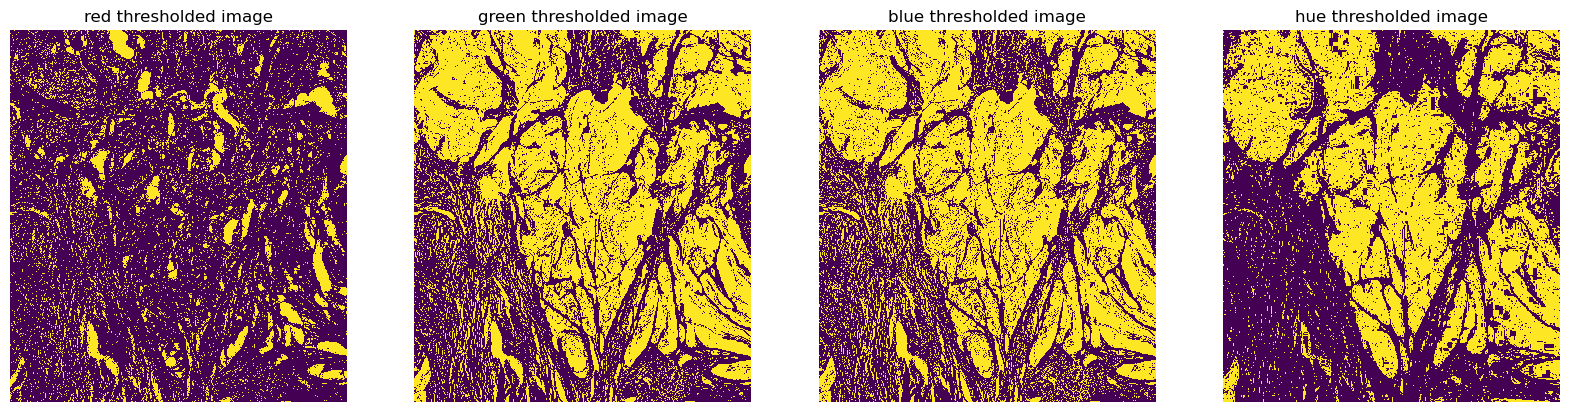

In [5]:
thresholds = [230,145,175, 210/255] # Found from the histogram where we took the local minimum for each channel

fig, axis = plt.subplots(1, 4, figsize=(20, 5))

masks = [imgs[i] > thresholds[i] for i in range(len(imgs)-1)] #rbg thresholds
masks.append(imgs[3] < thresholds[3]) # hue threshold
errors = [prediction_error(masks[i], adeno_gt) for i in range(len(masks))]

for ax, mask, channel in zip(axis, masks, channels):
    ax.imshow(mask, interpolation = "nearest")
    ax.set_title(channel + " thresholded image")
    ax.axis("off")
    

In [6]:
for error, color in zip(errors, channels):
    print("Error for " + color + " channel: " + str(error))


Error for red channel: 0.4897025596374086
Error for green channel: 0.2621464236116384
Error for blue channel: 0.27391050746708556
Error for hue channel: 0.20186639173077436


#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [7]:
mask_thesholding = masks[3] # hue masks based on error computations

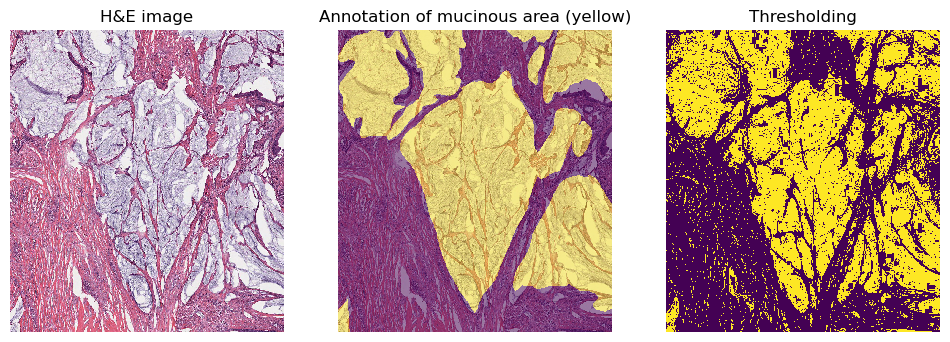

In [8]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(mask_thesholding, interpolation='nearest')
ax[2].imshow(mask_thesholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

In [9]:
import skimage.morphology as skmorph

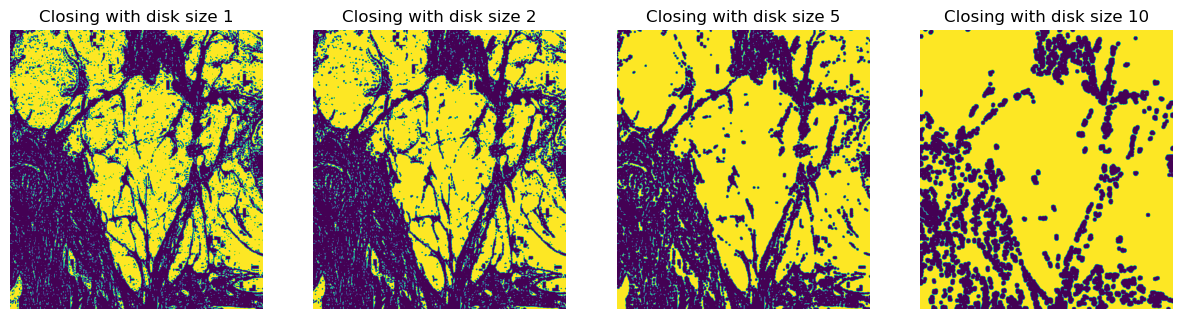

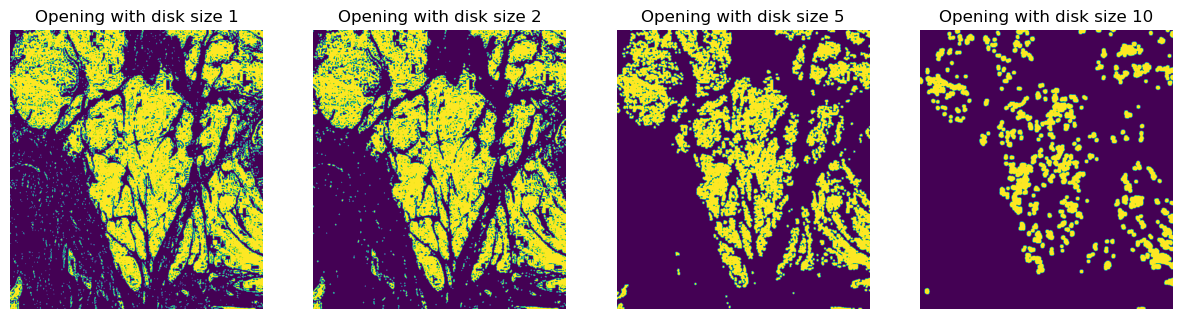

In [10]:
## PART A

disks = [1,2,5,10]
footprints = [skmorph.disk(size) for size in disks]
mask_thresholding_closing_disks = [skmorph.closing(mask_thesholding, footprints[i]) for i in range(len(footprints))]
mask_thresholding_opening_disks = [skmorph.opening(mask_thesholding, footprints[i]) for i in range(len(footprints))]

fig, axis = plt.subplots(ncols=4, figsize=(15, 4))
fig2, axis2 = plt.subplots(ncols=4, figsize=(15, 4))

for i in range(4):
    axis[i].imshow(mask_thresholding_closing_disks[i])
    axis[i].set_title("Closing with disk size " + str(disks[i]))
    axis[i].axis('off')
    
    axis2[i].imshow(mask_thresholding_opening_disks[i])
    axis2[i].set_title("Opening with disk size " + str(disks[i]))
    axis2[i].axis('off')


In [11]:
errors_a = [prediction_error(mask, adeno_gt) for mask in np.concatenate((mask_thresholding_closing_disks, mask_thresholding_opening_disks))]

for error, size in zip(errors_a[:4], disks):
    print("Error for closing transformation with " + str(size) + " disk: " + str(error))
    
for error, size in zip(errors_a[4:], disks):
    print("Error for opening transformation with " + str(size) + " disk: " + str(error))

Error for closing transformation with 1 disk: 0.18987450706435627
Error for closing transformation with 2 disk: 0.1790851856914092
Error for closing transformation with 5 disk: 0.16853885185016448
Error for closing transformation with 10 disk: 0.24948576076190088
Error for opening transformation with 1 disk: 0.19637386106625399
Error for opening transformation with 2 disk: 0.1941318511093899
Error for opening transformation with 5 disk: 0.2370798973377679
Error for opening transformation with 10 disk: 0.38945726597403973


## add comment part A

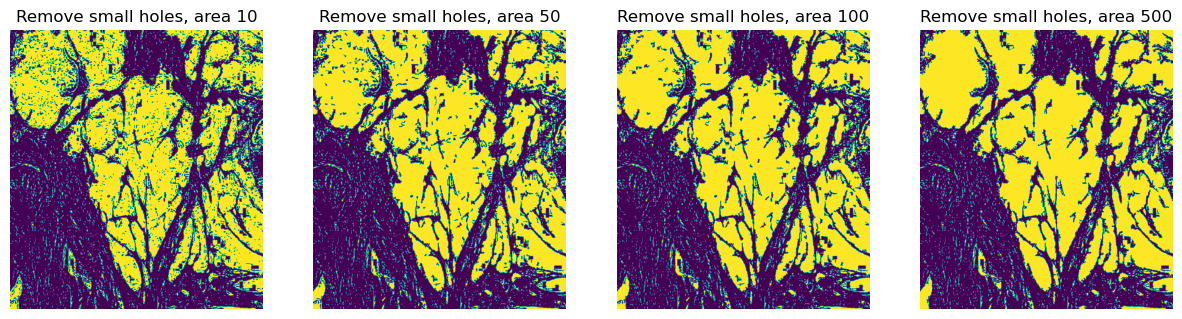

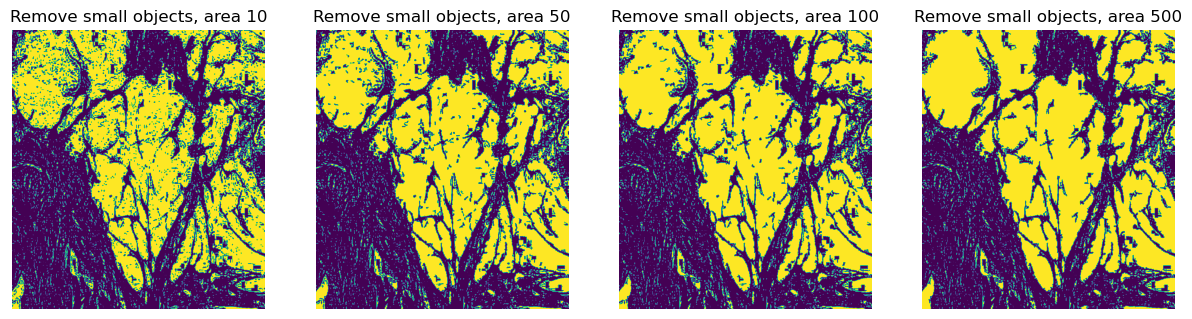

In [12]:
## PART B

holes = [10,50,100,500]
mask_thresholding_holes = [skmorph.remove_small_holes(mask_thesholding, area_threshold=size) for size in holes]
mask_thresholding_objects = [skmorph.remove_small_objects(mask_thesholding, min_size= size) for size in holes]

fig3, axis3 = plt.subplots(ncols=4, figsize=(15, 4))
fig4, axis4 = plt.subplots(ncols=4, figsize=(15, 4))

for axis, hole, mask, axis2 in zip(axis3, holes, mask_thresholding_holes, axis4):
    axis.imshow(mask)
    axis.set_title("Remove small holes, area " + str(hole))
    axis.axis('off')
    axis2.imshow(mask)
    axis2.set_title("Remove small objects, area " + str(hole))
    axis2.axis('off')

In [13]:
errors_b = [prediction_error(mask, adeno_gt) for mask in np.concatenate((mask_thresholding_holes, mask_thresholding_objects))]

for error, size in zip(errors_b[:4], disks):
    print("Error for removing small holes with " + str(size) + " disk: " + str(error))
    
for error, size in zip(errors_b[4:], disks):
    print("Error for removing small objects with " + str(size) + " disk: " + str(error))

Error for removing small holes with 1 disk: 0.19690820864754377
Error for removing small holes with 2 disk: 0.18221702498890524
Error for removing small holes with 5 disk: 0.1763903864682943
Error for removing small holes with 10 disk: 0.16601560632420054
Error for removing small objects with 1 disk: 0.19869967922270992
Error for removing small objects with 2 disk: 0.1884823909973119
Error for removing small objects with 5 disk: 0.1843291041128452
Error for removing small objects with 10 disk: 0.1765051305804871


## add comment part B

In [14]:
# PART C
mask_morph = np.zeros_like(adeno_gt)

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

In [15]:
mask_region = np.zeros_like(adeno_gt)
seeds = [(200,220),(300,350),(1,200),(100,1000),(500,500)]

for seed in seeds:
    pixels = []
    seen = []
    pixels.append(seed)
    
    while pixels:
        pxl = pixels.pop()
        if pxl in seen:
            continue
        if pxl[0] < 0 or pxl[0] >= imgs[1].shape[0] or pxl[1] < 0 or pxl[1] >= imgs[1].shape[1]:
            continue
        if imgs[1][pxl] < thresholds[1]:
            continue
        mask[pxl] = True
        seen.append(pxl)
        for i in range(-1, 2):
                for j in range(-1, 2):
                    if i == 0 and j == 0:
                        continue
                    neighbour = (pxl[0] + i, pxl[1] + j)
                    pixels.append(neighbour)
                    
                    
plt.imshow(mask_region)

KeyboardInterrupt: 

In [ ]:
# TODO
mask_region = np.zeros_like(adeno_gt)

---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

In [ ]:
# Add your comments here

In [ ]:
error_th = 1- (mask_thesholding == adeno_gt).mean()
error_morph = 1- (mask_morph == adeno_gt).mean()
error_region = 1- (mask_region == adeno_gt).mean()

# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thesholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))


[a.axis('off') for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

# ---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 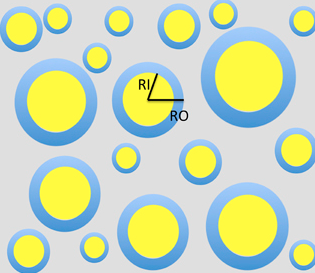

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 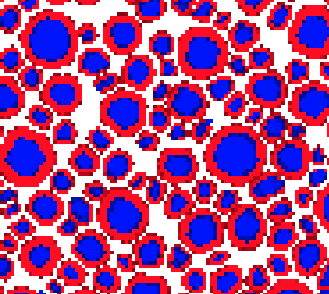

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.1 SNR

In [ ]:
data_base_path

In [ ]:
import cv2
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv2.imread(path_folder+ files[0])
snr_10 = cv2.imread(path_folder+ files[1])
snr_3 = cv2.imread(path_folder+ files[2])

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.1 Preprocessing 

 % add your images after preprocessing


In [ ]:
import cv2
import numpy as np

def segmentation(images):
    
    histograms = []
    segmented_images = []
    
    for i in range(0, len(images)):
        # Convert to grayscale
        gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to smooth the image
        # In case we are processing gt_0 we don't smooth the image as we don't have any noise
        if i == 0:
            gray_blur = gray
        else:
            gray_blur = cv2.GaussianBlur(gray, (5,5), 0)

        # Calculate the histogram
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        histograms.append(hist)

        #Set the thresholds, the values have been assigned by running different test and by interpretting the histograms
        #These values appeared to give the best compromise to have decent results for each files
        thresh1 = 120
        thresh2 = 180

        # Create a mask for each segment
        mask_blue = np.zeros_like(gray_blur)
        mask_blue[(gray_blur >= thresh1) & (gray_blur < thresh2)] = 255

        mask_red = np.zeros_like(gray_blur)
        mask_red[gray_blur < thresh1] = 255

        mask_white = np.zeros_like(gray_blur)
        mask_white[gray_blur >= thresh2] = 255

        # Create a color image from the masks
        segmented_img = np.zeros((images[i].shape[0], images[i].shape[1], 3), np.uint8)
        segmented_img[mask_blue > 0] = (0, 0, 255)   # blue
        segmented_img[mask_red > 0] = (255, 0, 0)    # red
        segmented_img[mask_white > 0] = (255, 255, 255)  # white
        
        segmented_images.append(segmented_img)

    return histograms, segmented_images

In [ ]:
histograms, segmented_images = segmentation(images)
fig, axs = plt.subplots(2,3, figsize=(20,12))
fig.suptitle("Histograms of grey pixels and segmented images")
for i in range(0, len(histograms)):
    axs[0,i].plot(histograms[i])
    axs.flat[i].set(xlabel='Pixel Intensity', ylabel='Frequency')
for i in range(0, len(segmented_images)):
    axs[1,i].imshow(segmented_images[i])

axs[0,0].set_title('gt_0')
axs[0,1].set_title('snr_10')
axs[0,2].set_title('snr_3')
axs[1,0].set_title('gt_0')
axs[1,1].set_title('snr_10')
axs[1,2].set_title('snr_3')

In [ ]:
# Threshold the image to create a binary image and then count the axons using contours
def count_axons(images):
    thresholds = []
    numbers = []
    for i in range(0, len(images)):
        gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        if i == 0:
            gray_blur = gray
        else:
            gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
        
        #Here we use the values 182, 255 based on our histograms and different tests, these values gave the best results
        ret, thresh = cv2.threshold(gray_blur, 182, 255, cv2.THRESH_BINARY)
        thresholds.append(thresh)
        contours = cv2.findContours(thresh, cv2.RETR_LIST,
                            cv2.CHAIN_APPROX_SIMPLE)[-2]

        # filter by area
        s1 = 0
        s2 = 1024
        ax_nbrs = [] #Stock the axons found with the contours and then can return the total number of axons by measuring its length
        for contour in contours:
            if s1 < cv2.contourArea(contour) < s2:
                ax_nbrs.append(contour)

        numbers.append(len(ax_nbrs))
        
    return thresholds, numbers

thresholds, numbers = count_axons(images)

fig, axs = plt.subplots(1,3, figsize=(24,12))
#fig.suptitle("Binary images")
for i in range(0, len(thresholds)):
    axs[i].imshow(thresholds[i])

axs[0].set_title('gt_0')
axs[1].set_title('snr_10')
axs[2].set_title('snr_3')

print('\n number of axons counted for gt_0: {}'.format(numbers[0]))
print('\n number of axons counted for snr_10: {}'.format(numbers[1]))
print('\n number of axons counted for snr_3: {}'.format(numbers[2]))

In [ ]:
def count_pixels(segmented_images):
    
    blue = []
    red = []
    for i in range(0, len(segmented_images)):
        # Define the color ranges
        blue_lower = np.array([0, 0, 200])
        blue_upper = np.array([0, 0, 255])
        red_lower = np.array([200, 0, 0])
        red_upper = np.array([255, 0, 0])

        # Create masks for blue and red pixels
        blue_mask = cv2.inRange(segmented_images[i], blue_lower, blue_upper)
        red_mask = cv2.inRange(segmented_images[i], red_lower, red_upper)

        # Count the number of blue and red pixels
        num_blue = cv2.countNonZero(blue_mask)
        num_red = cv2.countNonZero(red_mask)
        blue.append(num_blue)
        red.append(num_red)
    
    return blue, red

blue, red = count_pixels(segmented_images)

area_blue = [0.01*blue[0], 0.01*blue[1], 0.01*blue[2]]
area_red = [0.01*red[0], 0.01*red[1], 0.01*red[2]]

rad_inner = [np.sqrt(area_blue[0]/np.pi), np.sqrt(area_blue[1]/np.pi), np.sqrt(area_blue[2]/np.pi)]
rad_outer = [np.sqrt((area_red[0] + area_blue[0])/np.pi), np.sqrt((area_red[1] + area_blue[1])/np.pi)
             , np.sqrt((area_red[2] + area_blue[2])/np.pi)]


### 2.1.2 Results Segmetations

In [ ]:
images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(255- im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.3 Radii histrograms 

In [ ]:
## results Radii distribution. proposal feel free to change it
import numpy as np


rads_outer = np.random.normal(0, 1, 200)
rads_inner = np.random.normal(0, 1, 200)


rads_gt = [ rads_inner ,rads_outer]
rads_test0 = [ rads_inner ,rads_outer]  # your result
rads_test1 = [ rads_inner ,rads_outer]  # your result

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.2 Low frequencies

In [ ]:

files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder+ files[0])
lowfreq0 = cv2.imread(path_folder+ files[1])
lowfreq1 = cv2.imread(path_folder+ files[2])

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [ ]:
histograms, segmented_images = segmentation(images)
fig, axs = plt.subplots(2,3, figsize=(20,12))
fig.suptitle("Histograms of grey pixels and segmented images")
for i in range(0, len(histograms)):
    axs[0,i].plot(histograms[i])
    axs.flat[i].set(xlabel='Pixel Intensity', ylabel='Frequency')
for i in range(0, len(segmented_images)):
    axs[1,i].imshow(segmented_images[i])

axs[0,0].set_title('gt_3')
axs[0,1].set_title('low')
axs[0,2].set_title('lower')
axs[1,0].set_title('gt_3')
axs[1,1].set_title('low')
axs[1,2].set_title('lower')

In [ ]:
thresholds, numbers = count_axons(images)

fig, axs = plt.subplots(1,3, figsize=(24,12))
#fig.suptitle("Binary images")
for i in range(0, len(thresholds)):
    axs[i].imshow(thresholds[i])

axs[0].set_title('gt_0')
axs[1].set_title('snr_10')
axs[2].set_title('snr_3')

print('\n number of axons counted for gt_0: {}'.format(numbers[0]))
print('\n number of axons counted for snr_10: {}'.format(numbers[1]))
print('\n number of axons counted for snr_3: {}'.format(numbers[2]))

### 2.2.1 Preprocessing

For preprocessing we decided to use a Gaussian blur in order to smooth the image, when running different tests in appeared to be the most efficient to use with every test images. It offered us the best compromise to have decent results. 

For the GT images we decided not to preprocess them as there isn't any noise on these images, so the results were satisfying without smoothing them. On the contrary, the result became worse when trying to smooth the images. 

### 2.2.2 Results Segmetations

For the segmentation, we decided to plot the histograms with the different levels of grey on the picture. This allowed us to identify at which pixel intensity we should put our thresholds. 

In our tests you can see that the values we used as thresholds give good results when applying on GT images. When we run it with noisy or low frequencies images the results are still satisfying but we can see that it is not perfect and that we still have some noisy pixels on the background that are not white. 

We then binarized the images to isolate the axons from the background, this was done to be able to count the number of axons on each pictures. Here again it looked to work finely with the GT images. The results are also not bad with noisy images and gives results not far from the GT, with still some noise that is interpreted as axons or noise that make 2 axons touch each other which make them counted as one axon instead of two. 

For low frequencies images our result weren't so good for counting the axons, the images were too "compact", thus there is a lot of errors on the binarization and the axons cannot be counted nicely. We could avoid that using maybe another way to smooth the image or another way to count than binarization.

### 2.2.3 Radii histrograms

To calculte the inner and outer radii of each axons we decided to count the pixels of each colour to then know what area of the picture is the myelin and which is the inner part of the axons. Unfortunately, we were not able to plot the results properly so we were unable to test if our results were good enough or not.


### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

In [ ]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png" ]
real_data = cv2.imread(path_folder+ files[0])

plt.imshow(real_data[:256, :256])